<a href="https://colab.research.google.com/github/Entinosz/cs434/blob/main/O10V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Design**

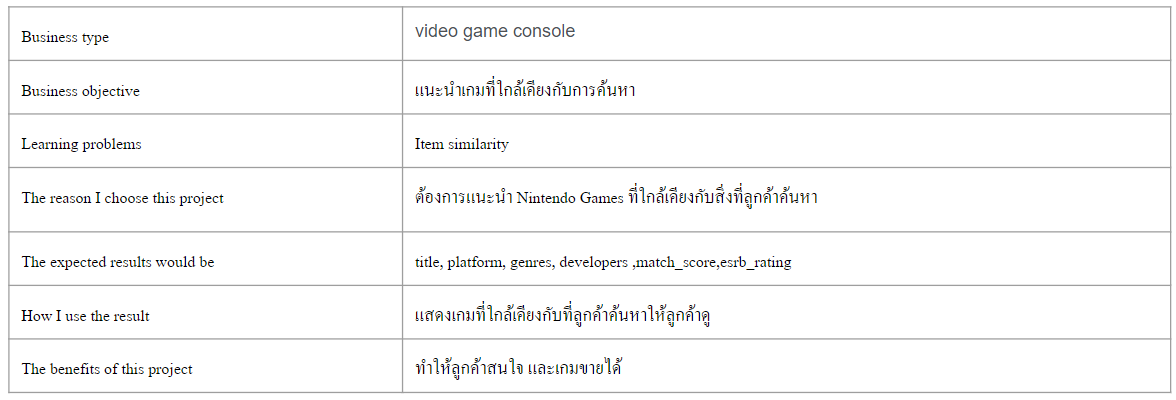

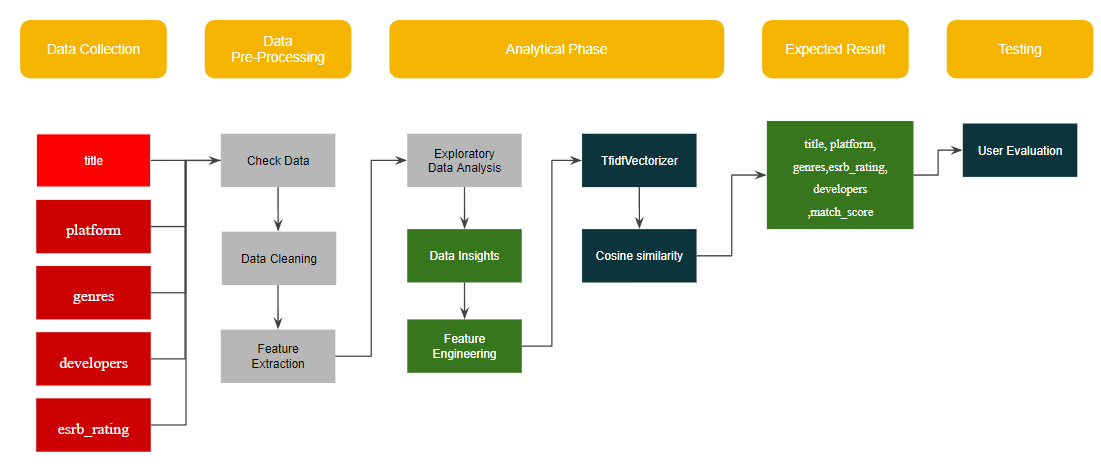

Nintendo Games Dataset

In [12]:
#เอามาตัดคำ
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#เอามาหาความเหมือนข้อมูล
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from scipy.sparse import hstack
import pandas as pd

import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

import time

# **Import data**

In [13]:
nintendo = pd.read_csv('https://raw.githubusercontent.com/Entinosz/cs434/main/data.csv')

In [14]:
#nintendo = pd.read_csv("data.csv")

In [15]:
df_nintendo = nintendo.copy()

# **Check**

In [16]:
df_nintendo.head()

,meta_score,title,platform,date,user_score,link,esrb_rating,developers,genres
0,NaN,Super Mario 3D World + Bowser's Fury,Switch,"Feb 12, 2021",NaN,/game/switch/super-mario-3d-world-+-bowsers-fury,NaN,['Nintendo'],"['Action', 'Platformer', '3D']"
1,NaN,Super Smash Bros. Ultimate: Sephiroth,Switch,"Dec 22, 2020",NaN,/game/switch/super-smash-bros-ultimate-sephiroth,NaN,['Nintendo'],"['Action', '2D', 'Fighting']"
2,66.0,Fitness Boxing 2: Rhythm & Exercise,Switch,"Dec 4, 2020",6.2,/game/switch/fitness-boxing-2-rhythm-exercise,E,"['Nintendo', ' Imagineer Co.', 'Ltd.']","['Miscellaneous', 'Exercise / Fitness']"
3,63.0,Fire Emblem: Shadow Dragon & the Blade of Light,Switch,"Dec 4, 2020",7.6,/game/switch/fire-emblem-shadow-dragon-the-bla...,E,['Intelligent Systems'],"['Strategy', 'Turn-Based', 'Tactics']"
4,79.0,Hyrule Warriors: Age of Calamity,Switch,"Nov 20, 2020",8.1,/game/switch/hyrule-warriors-age-of-calamity,T,"['Omega Force', ' Koei Tecmo Games']","['Action', ""Beat-'Em-Up"", '3D']"


In [17]:
df_nintendo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   meta_score   661 non-null    float64
 1   title        1026 non-null   object 
 2   platform     1026 non-null   object 
 3   date         1026 non-null   object 
 4   user_score   777 non-null    float64
 5   link         1026 non-null   object 
 6   esrb_rating  910 non-null    object 
 7   developers   1014 non-null   object 
 8   genres       1017 non-null   object 
dtypes: float64(2), object(7)
memory usage: 72.3+ KB


In [18]:
#เช็คข้อมูลซํ้า
df_nintendo.duplicated().sum()

0

In [19]:
#เช็คค่าว่าง
df_nintendo.isna().sum()

meta_score     365
title            0
platform         0
date             0
user_score     249
link             0
esrb_rating    116
developers      12
genres           9
dtype: int64

# **Data-Prepocessing**

In [20]:
df_nintendo.shape

(1026, 9)

In [21]:
#drop lum ที่ไม่ใช้
df_nintendo.drop(['meta_score', 'user_score', 'link', 'date'], axis=1, inplace=True)

In [22]:
#drop row ที่มีค่าnull
df_nintendo.dropna(axis=0 ,inplace=True)
df_nintendo.isna().sum()

title          0
platform       0
esrb_rating    0
developers     0
genres         0
dtype: int64

In [23]:
df_nintendo.shape

(908, 5)

In [24]:
df_nintendo.head()

,title,platform,esrb_rating,developers,genres
2,Fitness Boxing 2: Rhythm & Exercise,Switch,E,"['Nintendo', ' Imagineer Co.', 'Ltd.']","['Miscellaneous', 'Exercise / Fitness']"
3,Fire Emblem: Shadow Dragon & the Blade of Light,Switch,E,['Intelligent Systems'],"['Strategy', 'Turn-Based', 'Tactics']"
4,Hyrule Warriors: Age of Calamity,Switch,T,"['Omega Force', ' Koei Tecmo Games']","['Action', ""Beat-'Em-Up"", '3D']"
5,Pokemon Sword + Pokemon Sword Expansion Pass,Switch,E,['Game Freak'],"['Role-Playing', 'Trainer']"
6,Pokemon Shield + Pokemon Shield Expansion Pass,Switch,E,['Game Freak'],"['Role-Playing', 'Trainer']"


In [25]:
df_nintendo['title'] =  df_nintendo['title'].apply(lambda x: x.replace('[','').replace(']','').replace('/','').replace("'", "").replace('.','').replace(':',''))
df_nintendo['genres'] =  df_nintendo['genres'].apply(lambda x: x.replace('[','').replace(']','').replace('/','').replace("'", "").replace('.','').replace(':','').replace('"',''))
df_nintendo['developers'] =  df_nintendo['developers'].apply(lambda x: x.replace('[','').replace(']','').replace('/','').replace("'", "").replace('.','').replace(':',''))

In [26]:
df_nintendo.reset_index(drop=True,inplace=True)

In [27]:
df_nintendo.head()

,title,platform,esrb_rating,developers,genres
0,Fitness Boxing 2 Rhythm & Exercise,Switch,E,"Nintendo, Imagineer Co, Ltd","Miscellaneous, Exercise Fitness"
1,Fire Emblem Shadow Dragon & the Blade of Light,Switch,E,Intelligent Systems,"Strategy, Turn-Based, Tactics"
2,Hyrule Warriors Age of Calamity,Switch,T,"Omega Force, Koei Tecmo Games","Action, Beat-Em-Up, 3D"
3,Pokemon Sword + Pokemon Sword Expansion Pass,Switch,E,Game Freak,"Role-Playing, Trainer"
4,Pokemon Shield + Pokemon Shield Expansion Pass,Switch,E,Game Freak,"Role-Playing, Trainer"


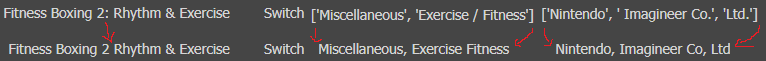

In [28]:
#ดูข้อมูลใน Colum rating เพื่อดูว่ามีกี่รูปแบบ
df_nintendo.groupby(['esrb_rating'])['esrb_rating'].count()

esrb_rating
E       629
E10+    125
M        14
RP        3
T       137
Name: esrb_rating, dtype: int64

-------------------------------------------------------------
* E = EVERYONE
* E10+ = EVERYONE 10+
* M = MATURE
* RP = RATING PENDING
* T = TEEN

In [29]:
#เรียกดูข้อมูล rating ที่ เท่ากับ RP เพื่อดูประเภทของเกม
df_nintendo.loc[df_nintendo['esrb_rating'] == 'RP']

,title,platform,esrb_rating,developers,genres
355,Chase Mii,WIIU,RP,Nintendo,"Miscellaneous, General"
794,Metroid Prime Hunters - First Hunt,DS,RP,Nintendo Software Technology,"Action, Shooter, First-Person, Arcade"
905,Wii U Play,WIIU,RP,Nintendo,"Miscellaneous, Party, Party Minigame"


In [30]:
#เอา rating ที่เท่ากับ RP ไปใส่รวมกับ T(Teen)
#เอา rating ที่เท่ากับ E10+ ไปใส่รวมกับ E(EVERYONE)
df_nintendo.loc[df_nintendo['esrb_rating'] == 'RP', ['esrb_rating']] = 'T'
df_nintendo.loc[df_nintendo['esrb_rating'] == 'E10+', ['esrb_rating']] = 'E'
df_nintendo.groupby(['esrb_rating'])['esrb_rating'].count()

esrb_rating
E    754
M     14
T    140
Name: esrb_rating, dtype: int64

In [31]:
df = df_nintendo.copy()

# **EDA**

In [32]:
def countgenres(data):
  dicts = {}
  for x in data:
    for y in x:
      if y not in dicts.keys():
        dicts[y] = 0
      dicts[y] = int(dicts[y])+1
  return dicts

In [33]:
GENRE = 'genres'
GENRE = df[GENRE].str.split(", ")
GENRE = countgenres(GENRE)
GENRE

{'2D': 171,
 '3D': 71,
 'Action': 322,
 'Action Adventure': 64,
 'Action RPG': 38,
 'Adventure': 19,
 'Alternative': 3,
 'Application': 11,
 'Arcade': 62,
 'Athletics': 7,
 'Automobile': 13,
 'Baseball': 3,
 'Basketball': 2,
 'Beat-Em-Up': 34,
 'Board  Card Game': 9,
 'Board Games': 16,
 'Boxing': 6,
 'Boxing  Martial Arts': 4,
 'Career': 5,
 'City Building': 1,
 'Civilian': 1,
 'Civilian Plane': 3,
 'Combat': 11,
 'Compilation': 21,
 'Console': 2,
 'Console-style RPG': 77,
 'Dancing': 1,
 'Defense': 2,
 'Driving': 39,
 'Edutainment': 31,
 'Exercise  Fitness': 7,
 'Fantasy': 139,
 'Fighting': 30,
 'First-Person': 16,
 'Flight': 3,
 'Football': 1,
 'Futuristic': 6,
 'Gambling': 1,
 'General': 311,
 'Golf': 10,
 'Hardware': 2,
 'Hidden Object': 3,
 'Historic': 3,
 'Horizontal': 1,
 'Horror': 4,
 'Hunting': 2,
 'Ice Hockey': 1,
 'Individual': 19,
 'Japanese-Style': 33,
 'Kart': 22,
 'Light Gun': 3,
 'Linear': 4,
 'Logic': 14,
 'Marine': 2,
 'Matching': 25,
 'Military': 2,
 'Miscellaneous'

In [34]:
colGenre = pd.DataFrame(data=GENRE.keys(),columns=['genre'])
rowGenre = pd.DataFrame(data=GENRE.values(),columns=['count_genre'])
colGenre.reset_index(inplace=True)
rowGenre.reset_index(inplace=True)
Genre = pd.merge(colGenre,rowGenre,on=['index','index'])
Genre

,index,genre,count_genre
0,0,Miscellaneous,239
1,1,Exercise Fitness,7
2,2,Strategy,82
3,3,Turn-Based,70
4,4,Tactics,62
...,...,...,...
109,109,Basketball,2
110,110,Dancing,1
111,111,Point-and-Click,1
112,112,On-foot,2


In [35]:
alt.Chart(Genre, title='Genre').mark_bar().encode(
    x='count_genre:Q',
    y=alt.Y('genre:O', sort='-x'),
    tooltip=list(Genre.columns)
).properties(width=800,height=600)


alt.Chart(...)

* ประเภท Action มากที่สุด 322 เรื่อง


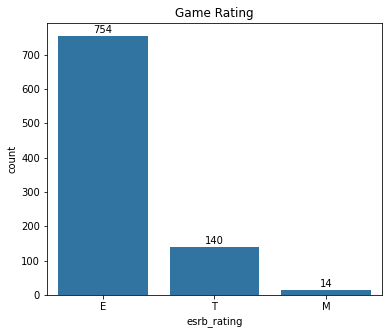

In [36]:
plt.figure(figsize=(6,5))
color=sns.color_palette()[0]
sns.countplot(data=df,x='esrb_rating',color=color,order=df.esrb_rating.value_counts().head(10).index);
plt.title('Game Rating');
locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = df.esrb_rating.value_counts()[label.get_text()]
    pct_string = '{:}'.format(count)
    plt.text(loc, count+10, pct_string, ha = 'center', color = 'black')

* Rating E เยอะที่สุด
-------------------------------------------------------------
* E = EVERYONE
* M = MATURE
* T = TEEN

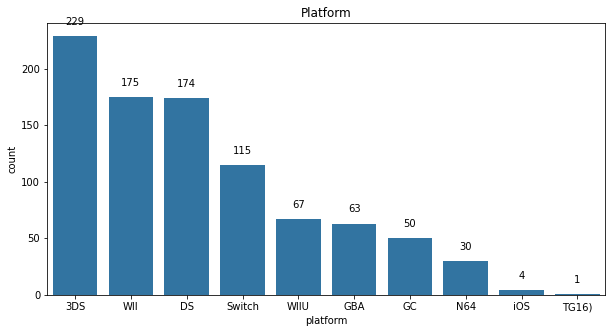

In [37]:
plt.figure(figsize=(10,5))
color=sns.color_palette()[0]
sns.countplot(data=df,x='platform',color=color,order=df.platform.value_counts().head(20).index);
plt.title('Platform');
locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = df.platform.value_counts()[label.get_text()]
    pct_string = '{:}'.format(count)
    plt.text(loc, count+10, pct_string, ha = 'center', color = 'black')

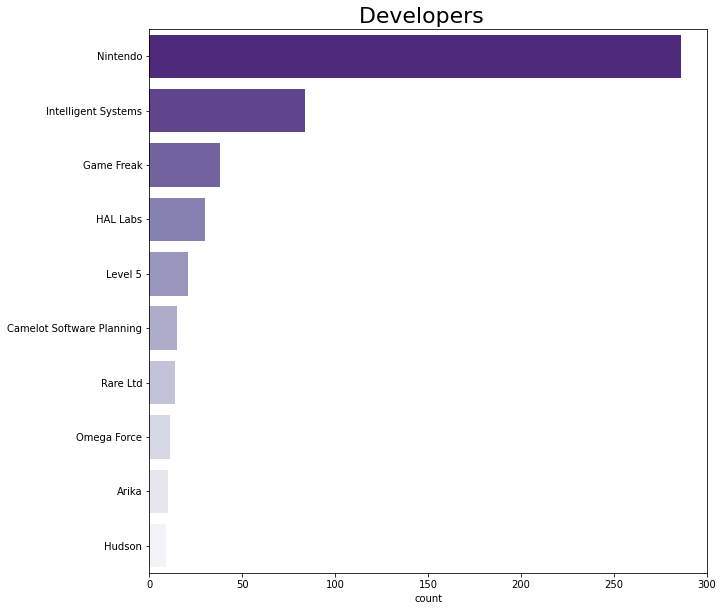

In [38]:
plt.figure(figsize=(10, 10))
developers_dict = dict(df[['developers']].groupby('developers')['developers'].count().nlargest(10))
data_plot = dict(sorted(developers_dict.items(),
                 key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
ax = sns.countplot(y=data_plot, palette='Purples_r')
ax.set_title('Developers  ',fontsize = 22)
 
plt.show()

# **Feature Engineering**

In [39]:
#เลือกที่จะใช้
mo = df_nintendo.reindex(columns=['title', 'platform','genres', 'developers', 'esrb_rating'])

In [40]:
#เอาข้อมูลมาต่อกัน
cols = ['platform','genres','developers','esrb_rating']

mo['alls'] = mo['title'].copy()
for i in cols:
  mo['alls'] += ' ' + mo[i]
mo['alls']

0      Fitness Boxing 2 Rhythm & Exercise Switch Misc...
1      Fire Emblem Shadow Dragon & the Blade of Light...
2      Hyrule Warriors Age of Calamity Switch Action,...
3      Pokemon Sword + Pokemon Sword Expansion Pass S...
4      Pokemon Shield + Pokemon Shield Expansion Pass...
                             ...                        
903    Pilotwings 64 N64 Simulation, General Paradigm...
904    Super Mario 64 N64 Action, Platformer, 3D Nint...
905    Wii U Play WIIU Miscellaneous, Party, Party  M...
906    ASH Archaic Sealed Heat DS Role-Playing, Strat...
907    Yo-kai Watch 4 Switch Role-Playing, Trainer Le...
Name: alls, Length: 908, dtype: object

In [41]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(mo['alls'])
cosine_sim_Tfid = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [42]:
cosine_sim_Tfid

array([[1.        , 0.03097595, 0.02667753, ..., 0.03879786, 0.        ,
        0.03984289],
       [0.03097595, 1.        , 0.03332037, ..., 0.        , 0.17010711,
        0.04976397],
       [0.02667753, 0.03332037, 1.        , ..., 0.        , 0.        ,
        0.0428584 ],
       ...,
       [0.03879786, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.17010711, 0.        , ..., 0.        , 1.        ,
        0.07592297],
       [0.03984289, 0.04976397, 0.0428584 , ..., 0.        , 0.07592297,
        1.        ]])

In [43]:

def get_rec(nam:str, cosine):

    ind = mo[mo['title'] == nam].index.to_list()[0]
    
    cos_score = list(enumerate(cosine[ind]))
    
    cos_score = sorted(cos_score, key=lambda x: x[1], reverse=True)
    cos_score = cos_score[0:10]
    ten_ind = [i[0] for i in cos_score]
    score = [i[1] for i in cos_score]
    score = [round(num, 4) for num in score]
    df = mo[['title','platform','genres','developers','esrb_rating']].iloc[ten_ind]

    df = pd.DataFrame({'title' : df['title'],
                       'platform':df['platform'],
                       'genres': df['genres'],
                       'developers': df['developers'],
                       'esrb_rating': df['esrb_rating'],
                       'match_score' : score
                       })

    return df

# **Modeling**

## Benchmark

### **Cosine Similarity**

TfidfVectorizer

In [44]:
#Tvec + Cosine
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(mo['alls'])

cosine_sim_Tfid = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [45]:
print('Using TfidfVectorizer\n')
get_rec("Mario vs Donkey Kong Tipping Stars", cosine_sim_Tfid)

Using TfidfVectorizer



,title,platform,genres,developers,esrb_rating,match_score
248,Mario vs Donkey Kong Tipping Stars,WIIU,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,1.0000
249,Mario vs Donkey Kong Tipping Stars,3DS,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,0.9643
734,Mario vs Donkey Kong 2 March of the Minis,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.6226
820,Mario vs Donkey Kong,GBA,"Action, Platformer, 2D",Nintendo,E,0.6016
445,Mario vs Donkey Kong Mini-Land Mayhem,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.5905
720,Donkey Kong,WII,"Action, Platformer, 2D",Nintendo,E,0.4939
556,Mario vs Donkey Kong Minis March Again!,DS,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,0.4773
602,Donkey Kong 3,WII,"Action, General, Platformer, 2D",Nintendo,E,0.4739
712,Donkey Kong Jr,WII,"Action, Platformer, 2D",Nintendo,E,0.3918
211,Mini-Mario & Friends amiibo Challenge,WIIU,"Puzzle, Action","Nintendo, Nintendo Software Technology",E,0.3877


CountVectorizer

In [46]:
#CountVectorizer + Cosine
count_vec = CountVectorizer(stop_words='english')
count_matrix = count_vec.fit_transform(mo['alls'])

cosine_sim_countV = cosine_similarity(count_matrix, count_matrix)

In [47]:
print('Using CountVectorizer\n')
get_rec("Mario vs Donkey Kong Tipping Stars", cosine_sim_countV)

Using CountVectorizer



,title,platform,genres,developers,esrb_rating,match_score
248,Mario vs Donkey Kong Tipping Stars,WIIU,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,1.0000
249,Mario vs Donkey Kong Tipping Stars,3DS,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,0.9412
734,Mario vs Donkey Kong 2 March of the Minis,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.7756
445,Mario vs Donkey Kong Mini-Land Mayhem,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.7586
820,Mario vs Donkey Kong,GBA,"Action, Platformer, 2D",Nintendo,E,0.7276
211,Mini-Mario & Friends amiibo Challenge,WIIU,"Puzzle, Action","Nintendo, Nintendo Software Technology",E,0.6482
556,Mario vs Donkey Kong Minis March Again!,DS,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,0.6471
720,Donkey Kong,WII,"Action, Platformer, 2D",Nintendo,E,0.6417
233,Super Mario Maker,WIIU,"Action, Platformer, 2D",Nintendo,E,0.6002
602,Donkey Kong 3,WII,"Action, General, Platformer, 2D",Nintendo,E,0.6002



**TfidfVectorizer**

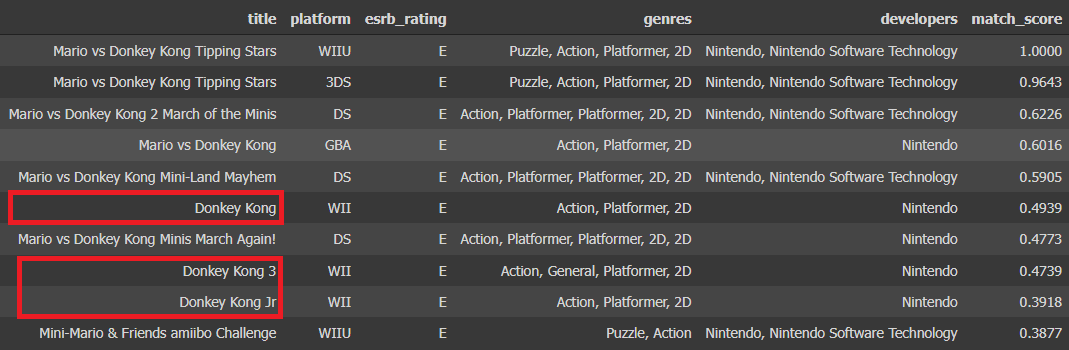

CountVectorizer

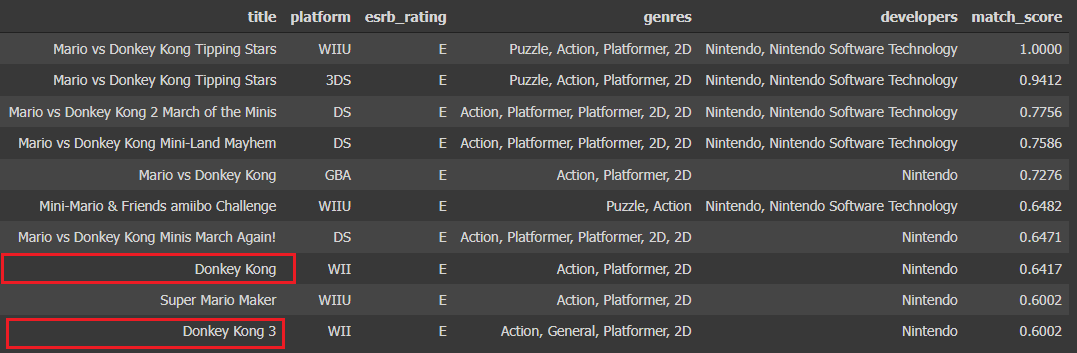

* TfidfVectorizer + Cosine Similarity ได้ 0.03
* CountVectorizer + Cosine Similarity ได้ 0.04

### **Linear Kernel**

TfidfVectorizer

In [48]:
# Tvec + LinearKernel
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(mo['alls'])
cosine_kernel_Tfid = linear_kernel(tfidf_matrix, tfidf_matrix)

In [49]:
get_rec("Mario vs Donkey Kong Tipping Stars", cosine_kernel_Tfid)

,title,platform,genres,developers,esrb_rating,match_score
248,Mario vs Donkey Kong Tipping Stars,WIIU,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,1.0000
249,Mario vs Donkey Kong Tipping Stars,3DS,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,0.9643
734,Mario vs Donkey Kong 2 March of the Minis,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.6226
820,Mario vs Donkey Kong,GBA,"Action, Platformer, 2D",Nintendo,E,0.6016
445,Mario vs Donkey Kong Mini-Land Mayhem,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.5905
720,Donkey Kong,WII,"Action, Platformer, 2D",Nintendo,E,0.4939
556,Mario vs Donkey Kong Minis March Again!,DS,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,0.4773
602,Donkey Kong 3,WII,"Action, General, Platformer, 2D",Nintendo,E,0.4739
712,Donkey Kong Jr,WII,"Action, Platformer, 2D",Nintendo,E,0.3918
211,Mini-Mario & Friends amiibo Challenge,WIIU,"Puzzle, Action","Nintendo, Nintendo Software Technology",E,0.3877


CountVectorizer

In [50]:
# CountVectorizer + LinearKernel
count_vec = CountVectorizer(stop_words='english')
count_matrix = count_vec.fit_transform(mo['alls'])
cosine_kernel_countV = linear_kernel(count_matrix, count_matrix)

In [51]:
 print('Using CountVectorizer\n')
get_rec("Mario vs Donkey Kong Tipping Stars", cosine_kernel_countV)

Using CountVectorizer



,title,platform,genres,developers,esrb_rating,match_score
248,Mario vs Donkey Kong Tipping Stars,WIIU,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,17.0
249,Mario vs Donkey Kong Tipping Stars,3DS,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,16.0
445,Mario vs Donkey Kong Mini-Land Mayhem,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,15.0
734,Mario vs Donkey Kong 2 March of the Minis,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,15.0
556,Mario vs Donkey Kong Minis March Again!,DS,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,11.0
211,Mini-Mario & Friends amiibo Challenge,WIIU,"Puzzle, Action","Nintendo, Nintendo Software Technology",E,10.0
212,Mini-Mario & Friends amiibo Challenge,3DS,"Puzzle, Action","Nintendo, Nintendo Software Technology",E,9.0
315,Mario and Donkey Kong Minis on the Move,3DS,"Puzzle, Action, Platformer, Platformer, 3D, 3D",Nintendo,E,9.0
363,New Super Mario Bros U,WIIU,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,9.0
562,New Play Control! Donkey Kong Jungle Beat,WII,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,9.0


TfidfVectorizer

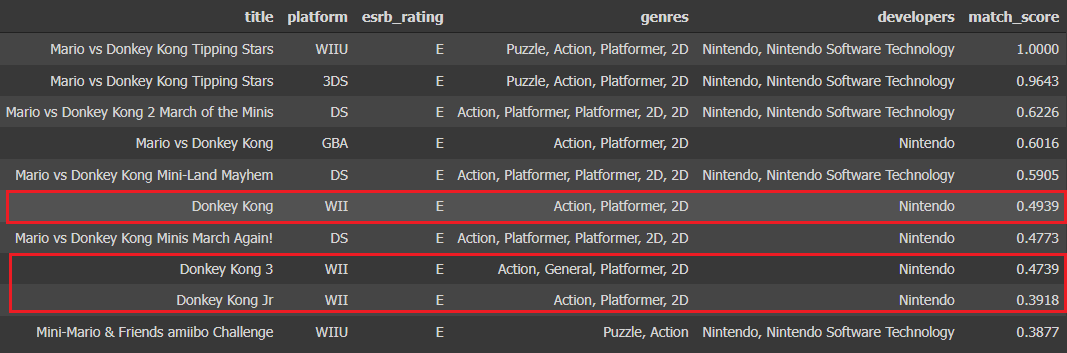

CountVectorizer

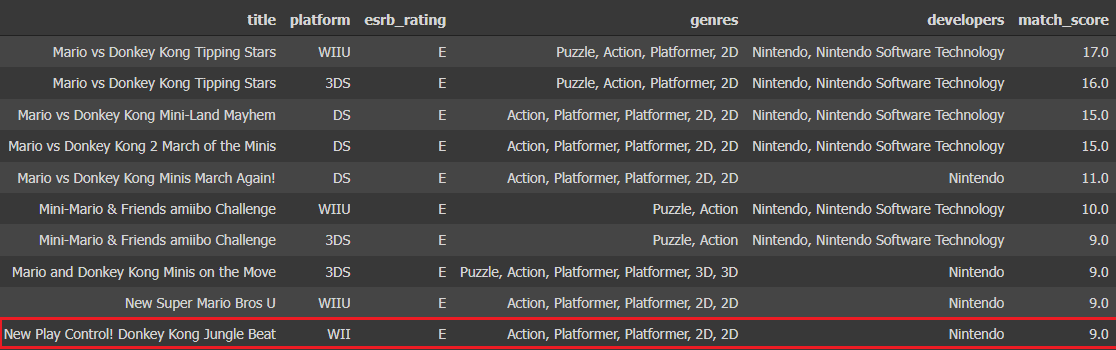

* TfidfVectorizer + Linear kernal ได้ 0.04
* CountVectorizer + Linear kernal ได้ 0.04

### **Performance**

In [52]:
#start = time.time()
#tfidf = TfidfVectorizer(stop_words='english')
#tfidf_matrix = tfidf.fit_transform(mo['alls'])
#cosine_sim_Tfid = cosine_similarity(tfidf_matrix, tfidf_matrix)
#timeTfid1 = round(time.time() - start,2)
#print("TfidfVectorizer + Cosine Similarity : %.2f s"%(timeTfid1))

In [53]:
#start = time.time()
#count_vec = CountVectorizer(stop_words='english')
#count_matrix = count_vec.fit_transform(mo['alls'])
#cosine_sim_countV = cosine_similarity(count_matrix, count_matrix)
#timeCountV1 = round(time.time() - start,2)
#print("CountVectorizer + Cosine Similarity : %.2f s"%(timeCountV1))

In [54]:
#start = time.time()
#tfidf = TfidfVectorizer(stop_words='english')
#tfidf_matrix = tfidf.fit_transform(mo['alls'])
#cosine_kernel_Tfid = linear_kernel(tfidf_matrix, tfidf_matrix)
#timeTfid2 = round(time.time() - start,2)
#print("TfidfVectorizer + Linear kernal : %.2f s"%(timeTfid2))

In [55]:
#start = time.time()
#count_vec = CountVectorizer(stop_words='english')
#count_matrix = count_vec.fit_transform(mo['alls']) 
#cosine_kernel_countV = linear_kernel(count_matrix, count_matrix)
#timeCountV2 = round(time.time() - start,2)
#print("ountVectorizer + Linear kernal : %.2f s"%(timeCountV2))

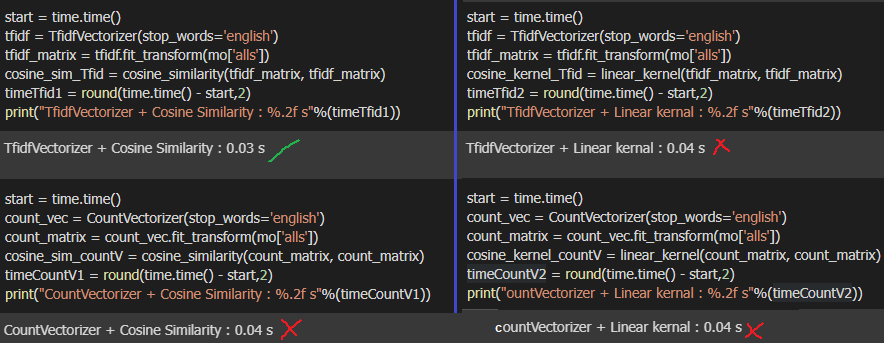

* TfidfVectorizer + Cosine Similarity ได้ 0.03
* CountVectorizer + Cosine Similarity ได้ 0.04
* TfidfVectorizer + Linear kernal ได้ 0.04
* CountVectorizer + Linear kernal ได้ 0.04

### **สรุป**

เลือก TfidfVectorizer + Cosine Similarity 

# **Pipeline**

In [56]:
class PipeLine():
    def __init__(self,data):
        self.data = data.copy()

    def dtf(self, data):

      data = pd.DataFrame({'title' : data['title'],
                       'platform':data['platform'],
                       'genres': data['genres'],
                       'developers': data['developers'],
                       'esrb_rating': data['esrb_rating']
                       })
    
      cols = ['platform', 'genres', 'developers']
      data['alls'] = data['title'].copy()
      for i in cols:
        data['alls'] += ' ' + data[i]
      return data
    
    def tfidf_fit_transform(self, data):
      tfidf = TfidfVectorizer(stop_words='english')
      fidf_matrix = tfidf.fit_transform(data['alls'])
      return fidf_matrix
    
    def execution(self, data):
      df = data.copy()
      df = self.dtf(df)

      return self.tfidf_fit_transform(df)

In [57]:
pipeline = PipeLine(df_nintendo)

In [58]:
tfidf_matrix = pipeline.execution(df_nintendo) 

Display Out put of Pipiline

In [59]:
tfidf_matrix

<908x1243 sparse matrix of type '<class 'numpy.float64'>'
	with 8621 stored elements in Compressed Sparse Row format>

In [60]:
cosine_sim_Tfid = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [61]:
get_rec("Mario vs Donkey Kong Tipping Stars", cosine_sim_Tfid)

,title,platform,genres,developers,esrb_rating,match_score
248,Mario vs Donkey Kong Tipping Stars,WIIU,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,1.0000
249,Mario vs Donkey Kong Tipping Stars,3DS,"Puzzle, Action, Platformer, 2D","Nintendo, Nintendo Software Technology",E,0.9643
734,Mario vs Donkey Kong 2 March of the Minis,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.6226
820,Mario vs Donkey Kong,GBA,"Action, Platformer, 2D",Nintendo,E,0.6016
445,Mario vs Donkey Kong Mini-Land Mayhem,DS,"Action, Platformer, Platformer, 2D, 2D","Nintendo, Nintendo Software Technology",E,0.5905
720,Donkey Kong,WII,"Action, Platformer, 2D",Nintendo,E,0.4939
556,Mario vs Donkey Kong Minis March Again!,DS,"Action, Platformer, Platformer, 2D, 2D",Nintendo,E,0.4773
602,Donkey Kong 3,WII,"Action, General, Platformer, 2D",Nintendo,E,0.4739
712,Donkey Kong Jr,WII,"Action, Platformer, 2D",Nintendo,E,0.3918
211,Mini-Mario & Friends amiibo Challenge,WIIU,"Puzzle, Action","Nintendo, Nintendo Software Technology",E,0.3877


#**Deployment**

In [62]:
!pip install gradio -q

     |████████████████████████████████| 981 kB 5.4 MB/s 
     |████████████████████████████████| 206 kB 8.2 MB/s 
     |████████████████████████████████| 2.0 MB 34.8 MB/s 
     |████████████████████████████████| 961 kB 41.4 MB/s 
     |████████████████████████████████| 3.6 MB 16.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [63]:
import gradio as gr

In [64]:
def deployReccomendations(name):
  df = get_rec(name, cosine_sim_Tfid)
  return df

In [65]:
title_input = gr.inputs.Textbox(label='Nintendo Games',default="Mario vs Donkey Kong Tipping Stars")
result = gr.outputs.Dataframe(label='Your App')
iface = gr.Interface(deployReccomendations,inputs=title_input,outputs=result)
iface.launch()
 

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://35396.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://35396.gradio.app')

# **Ref**


1.   Dataset
* https://www.kaggle.com/mrmorj/nintendo-games-dataset




2.  EDA
* https://www.kaggle.com/mishabz4321/bmw-used-car-price-prediction

* https://www.kaggle.com/sumeetsawant/bmw-price-prediction-deep-learning

3.   Ref.
*   https://colab.research.google.com/github/king-glitch/cs-434/blob/main/index.ipynb#scrollTo=Z3lsmbs4Yc1z

*   https://colab.research.google.com/github/MacClay/CS434/blob/main/cs434_finalexam__%E0%B8%AD%E0%B8%B5%E0%B8%AB%E0%B8%A2%E0%B8%B1%E0%B8%87%E0%B8%A7%E0%B8%B0_%E0%B8%AB%E0%B9%89%E0%B8%A7%E0%B8%A2_!_.ipynb#scrollTo=1BszslzukVbc

* https://colab.research.google.com/github/Parisleah/cs434_finalexam/blob/main/cs434_finalexam__Hon%E0%B8%95%E0%B8%B5%E0%B9%895.ipynb#scrollTo=-uzQ0YFJl0Fb


4. Information
* https://www.xbox.com/en-US/games/gameratings







# **Members**

1620704658 นายปฏิพล แก้วบูชา (Design,Dev)

1620702603 ธีรภัทร ชราชิต (Visualizer)